In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
base_dir = '/kaggle/input/fruit-ripeness-classification'
fruit_classes = ['apple', 'banana', 'mango', 'durian']
image_size = (128, 128)  # Resize images to this size

# Initialize lists to hold images and labels
images = []
labels = []

# Load images and their corresponding labels
for label, fruit in enumerate(fruit_classes):
    fruit_dir = os.path.join(base_dir, fruit)
    for filename in os.listdir(fruit_dir):
        img_path = os.path.join(fruit_dir, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0  # Scale pixel values to [0, 1]

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator()  # No augmentation for validation

In [4]:
# Fit the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size[0], image_size[1], 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(fruit_classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,196 (16.36 MB)

 Trainable params: 4,288,196 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

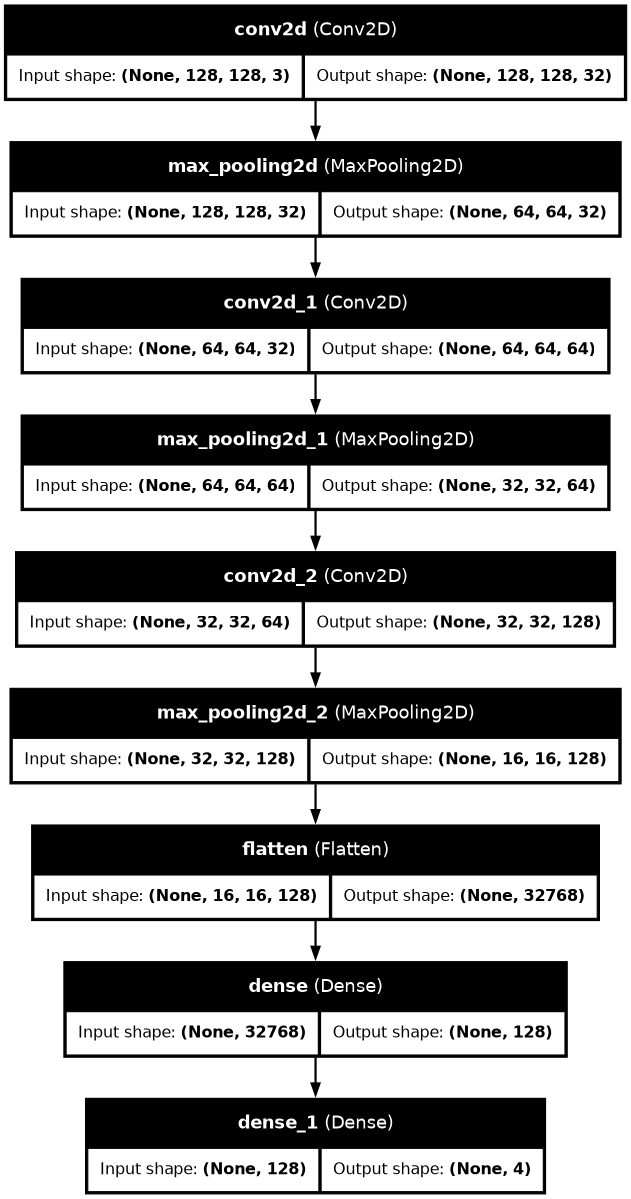

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, dpi=80)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Fit the model using the data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val)

# Define EarlyStopping with patience of 3
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1,
                               restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=25,  # Change the number of epochs as needed
                    verbose=1,
                    # callbacks=[early_stopping]
                   )

Epoch 1/25


I0000 00:00:1732437960.978645      69 service.cc:145] XLA service 0x7a8b580049f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732437960.978707      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732437960.978719      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/216 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.4028 - loss: 1.4179

I0000 00:00:1732437964.666540      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


216/216 ━━━━━━━━━━━━━━━━━━━━ 34s 131ms/step - accuracy: 0.5574 - loss: 0.9660 - val_accuracy: 0.7743 - val_loss: 0.5073
Epoch 2/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - accuracy: 0.7895 - loss: 0.4827 - val_accuracy: 0.8500 - val_loss: 0.3744
Epoch 3/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.8628 - loss: 0.3288 - val_accuracy: 0.8926 - val_loss: 0.2714
Epoch 4/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.8950 - loss: 0.2633 - val_accuracy: 0.9250 - val_loss: 0.1776
Epoch 5/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.9094 - loss: 0.2196 - val_accuracy: 0.9412 - val_loss: 0.1373
Epoch 6/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.9216 - loss: 0.1971 - val_accuracy: 0.9412 - val_loss: 0.1528
Epoch 7/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.9267 - loss: 0.1754 - val_accuracy: 0.9203 - val_loss: 0.2152
Epoch 8/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9358 - loss: 0.1565 - val

In [7]:
# Evaluate the model on the test set
test_generator = val_datagen.flow(X_test, y_test)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test Accuracy: {test_acc:.2f}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9825 - loss: 0.0497
Test Accuracy: 0.98


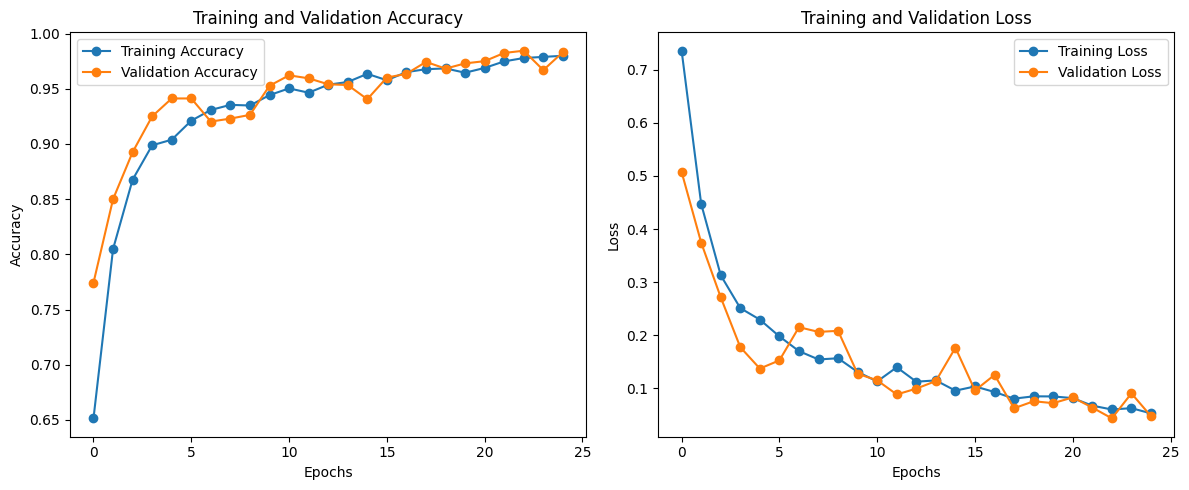

In [8]:
import matplotlib.pyplot as plt

# Extract the history dictionary
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


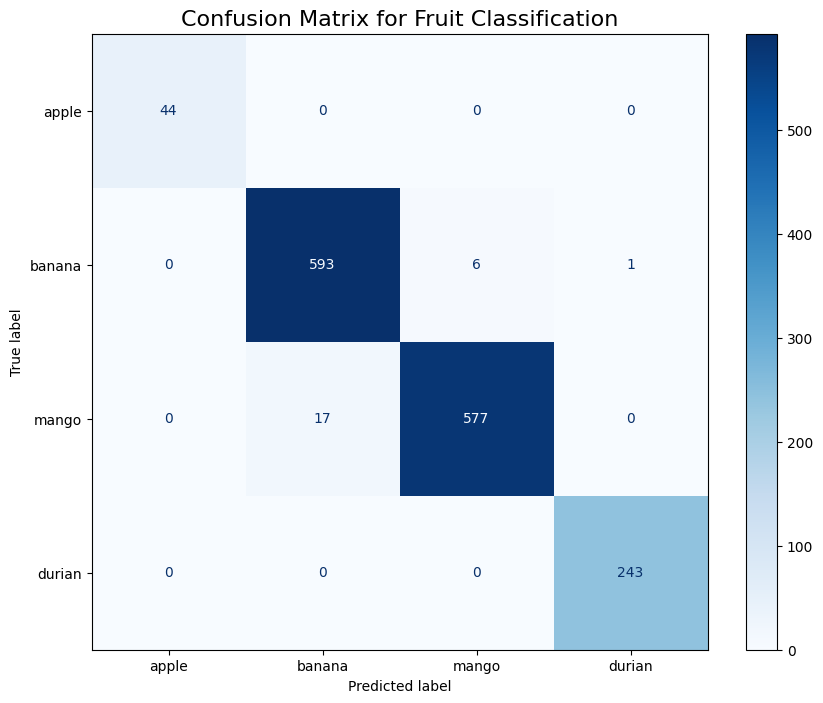

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions on the test set
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fruit_classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax)

# Add a title
ax.set_title("Confusion Matrix for Fruit Classification", fontsize=16)

# Show the plot
plt.show()

In [10]:
# Save the model to /kaggle/working directory
model.save('/kaggle/working/fruit_ripeness_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


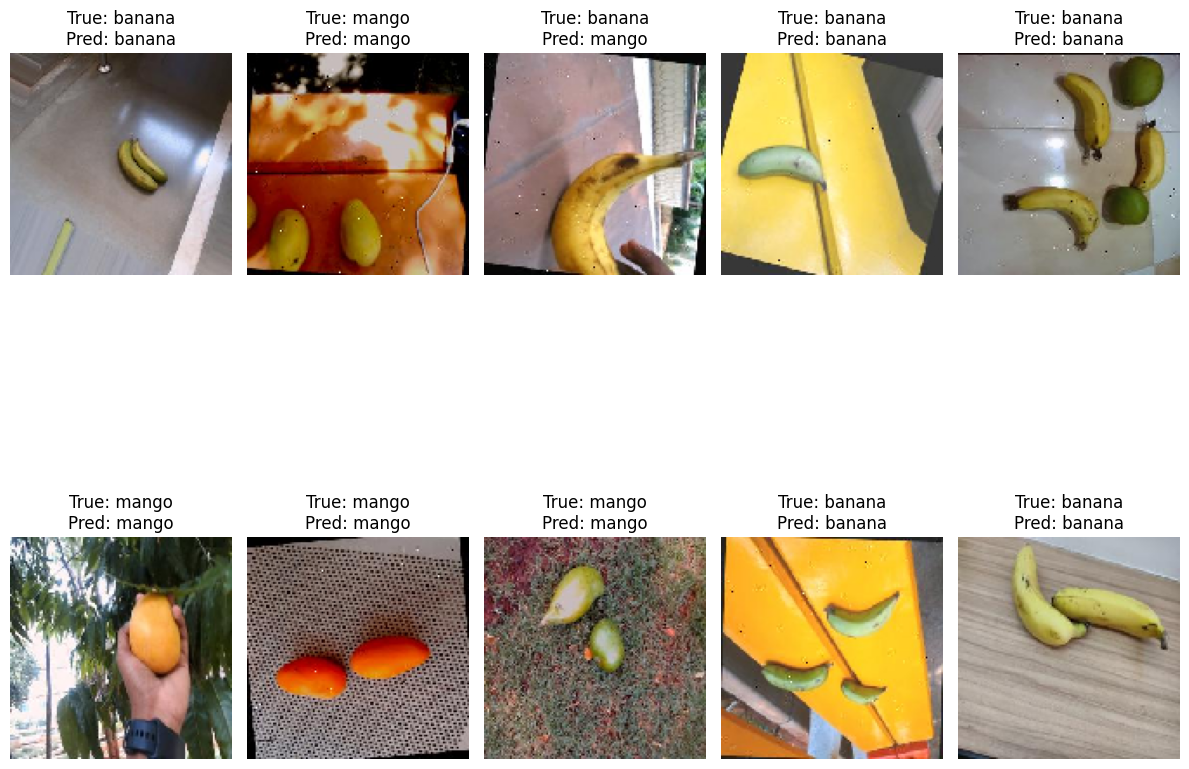

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Pick 10 random indices from the test set
random_indices = np.random.choice(len(X_test), size=10, replace=False)

# Get the images and corresponding true labels
random_images = X_test[random_indices]
random_labels = y_test[random_indices]

# Predict the labels using the trained model
predictions = model.predict(random_images)

# Get the class labels (fruit names) based on the predicted class indices
predicted_labels = np.argmax(predictions, axis=1)

# Map the class indices back to the fruit names
fruit_classes = ['apple', 'banana', 'mango', 'durian']
predicted_labels_names = [fruit_classes[label] for label in predicted_labels]
true_labels_names = [fruit_classes[label] for label in random_labels]

# Plot the images and show the predicted and true labels
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_images[i])
    plt.title(f"True: {true_labels_names[i]}\nPred: {predicted_labels_names[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()